# **TP1 - Saxeburg traffic**
Se debe generar el grafo, realizar un analisis exploratorio, aplicar algoritmos y algunas funciones de Python

***Las respuestas se deben adjuntar debajo de cada pregunta, usando python.***

# Grupo 5
Integrantes: German Beldorati Stark, Maria Bondarchuk, Paula Brankevich, Florencia Varise

---

*Importante: ANTES de comenzar la ejecucion*:

 1. Crear en Neo4j una nueva base local llamada "Saxeburg Traffic". 

 2. Instalar el plugin Graph Data Science Library (GDS) para esta nueva base.

 3. Instalar el plugin APOC para esta nueva base.

  *NOTA:* en la clase 2, documento GM - Practica2-2, se indica como realizar estos tres primeros pasos.

 4. Instalar las librerías neo4j y py2neo.
 
     - Desde Anaconda, abrir un prompt, y ejecutar:
          - pip install neo4j
          - pip install py2neo
 
 
 5. Abrir Neo4j Browser para esa base.

**CARGA DE LOS DATOS**

Los nodos, relaciones y propiedades se encuentran en:

*saxeburg_traffic_crea.cyp*

In [1]:
# El package neo4j se tuvo que instalar previamente desde Anaconda.
from neo4j import GraphDatabase

In [3]:
# Esta clase Python define la conexion a la base y permite ejecutar sentencias cypher
class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

# Conexion a la base 

Observar aqui de cambiar la password del usuario neo4j, por la de la base propia
Si se requiere modificar la password, desde Neo4j ejecutar ALTER USER neo4j SET PASSWORD 'xxxx';

El port puede ser `7687` u `11003` u `11006`, etc. Se encuentra al abrir Neo4j Browser, en la parte superior 
(Por ejemplo: neo4j@bolt://localhost:11006/neo4j)

In [4]:
host = "bolt://localhost:7687"
user = "neo4j"
password = "1234"

conn = Neo4jConnection(uri=host, user=user, pwd=password)

In [5]:
# Importando librerias de Python
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels as sm

**ANALISIS EXPLORATORIO**    

##### 1) Mostrar el modelo de datos 

In [5]:
conn.query("MATCH (n) RETURN n")

[<Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:0' labels=frozenset({'Metro'}) properties={'name': 'Cavite Island'}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:1' labels=frozenset({'Metro'}) properties={'name': 'St Germain'}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:2' labels=frozenset({'Metro'}) properties={'name': 'Pigalle'}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:3' labels=frozenset({'Metro'}) properties={'name': 'Montreal'}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:4' labels=frozenset({'Metro'}) properties={'name': 'Quebec'}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:5' labels=frozenset({'Metro'}) properties={'name': 'Fort Tilden'}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:6' labels=frozenset({'Metro'}) properties={'name': 'Intramuros'}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c

In [30]:
conn.query("CALL gds.graph.project.cypher('saxeburg_traffic', 'MATCH (n:Metro) RETURN id(n) AS id', 'MATCH (a:Metro)-[:HAS_ROUTE]-(b:Metro) RETURN id(a) AS source, id(b) AS target') YIELD graphName, nodeCount, relationshipCount")

[<Record graphName='saxeburg_traffic' nodeCount=23 relationshipCount=64>]

In [31]:
conn.query("CALL db.schema.visualization()")

[<Record nodes=[<Node element_id='-3' labels=frozenset({'Metro'}) properties={'name': 'Metro', 'indexes': [], 'constraints': []}>] relationships=[<Relationship element_id='-3' nodes=(<Node element_id='-3' labels=frozenset({'Metro'}) properties={'name': 'Metro', 'indexes': [], 'constraints': []}>, <Node element_id='-3' labels=frozenset({'Metro'}) properties={'name': 'Metro', 'indexes': [], 'constraints': []}>) type='HAS_ROUTE' properties={}>]>]

##### 2) Cuantos nodos se crearon (Orden del grafo)? de que se tratan?  

Se tratan de estaciones de Metro.

In [18]:
conn.query("match (n) return count(n)")

[<Record count(n)=23>]

##### 3) Cuantas propiedades tienen los nodos? Cual son, en caso afirmativo?

Tienen una sola propiedad, llamada "name" y corresponde al nombre de la estación.

In [92]:
conn.query("match (n:Metro) return keys(n)")

[<Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>,
 <Record keys(n)=['name']>]

##### 4) Cuantas relaciones se crearon (Medida del grafo)?     

Hay 32 relaciones entre los nodos.

In [39]:
conn.query("MATCH ()-[f:HAS_ROUTE]->() RETURN count(f)")

[<Record count(f)=32>]

##### 5) Las relaciones tienen propiedades? Cual son, en caso afirmativo?   

Tienen dos propiedades, "travelTime" y "status". La primera corresponde al tiempo de viaje entre dos estaciones, y la segunda al estado de la relación.

In [40]:
conn.query("MATCH ()-[f:HAS_ROUTE]->() RETURN properties(f)")

[<Record properties(f)={'travelTime': 3, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 2.5, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 5.6, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 9, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 8.5, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 4, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 6, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 3, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 13, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 16.5, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 11, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 12.5, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 4.5, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 7.5, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime': 1.5, 'status': 'ACTIVE'}>,
 <Record properties(f)={'travelTime

**ANALISIS DE LOS NODOS**

##### 6) Existen nodos con todas las propiedades? Cuantos son, en caso afirmativo?

Si, los 23 nodos tienen la propiedad "name" (la única que hay).

In [93]:
conn.query("MATCH (n) WHERE keys(n) = ['name'] RETURN count(n)")

[<Record count(n)=23>]

##### 7) Existen nodos sin propiedades? Cuantos son, en caso afirmativo?

No hay nodos sin propiedades.

In [95]:
conn.query("MATCH (n) WHERE properties(n) = {} RETURN count(n)")

[<Record count(n)=0>]

##### 8) Existen nodos sin relaciones con otros nodos? (nodos aislados)

No existen nodos aislados

In [98]:
conn.query("""MATCH (n)
           WHERE NOT (n)--()
           RETURN n""")

[]

#### ANALISIS DEL GRAFO

##### 9) Cuales son los 4 nodos que tienen mas relaciones. (los nodos con mayor grado)

Tomando relaciones en ambas direcciones, los 4 nodos con mayor grado son:

In [105]:
conn.query("MATCH (n)<-[r]->() RETURN n, count(r) AS degree order by degree desc limit 4")

[<Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:7' labels=frozenset({'Metro'}) properties={'name': 'China Town'}> degree=6>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:15' labels=frozenset({'Metro'}) properties={'name': 'NYC'}> degree=5>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:6' labels=frozenset({'Metro'}) properties={'name': 'Intramuros'}> degree=5>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:19' labels=frozenset({'Metro'}) properties={'name': 'Bastille'}> degree=5>]

##### 10) Si tiene en cuenta el tiempo de viaje entre estaciones, cuales son las 4 estaciones que suman mas tiempo hasta llegar a todas las estaciones adyacentes. Son las mismas que en el punto anterior?

3 de las estaciones son las mismas, pero Puerto del Postigo no está entre las 4 primeras, por lo que probablemente esté alejada de sus (pocas) estaciones adyacentes.

In [13]:
conn.query("""
           MATCH (n)-[r:HAS_ROUTE]-()
           WITH n, sum(r.travelTime) AS time
           RETURN n.name, time
           ORDER BY time DESC
           LIMIT 4
           """)


[<Record n.name='NYC' time=88.5>,
 <Record n.name='Puerto del Postigo' time=78.5>,
 <Record n.name='China Town' time=47.1>,
 <Record n.name='Bastille' time=45.5>]

##### 11) Mostrar la lista de estaciones para los caminos mas cortos entre las siguientes estaciones:
- 11.1) "Quebec" y "Bastille"

In [16]:
q_b_shortest = conn.query("""MATCH (q:Metro {name: 'Quebec'}),
                          (b:Metro {name : 'Bastille'}),
                          p=shortestPath((q)-[*]-(b))
                          RETURN p""")
for record in q_b_shortest:
    nodes = record["p"].nodes
    for node in nodes:
        print(node)

<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:4' labels=frozenset({'Metro'}) properties={'name': 'Quebec'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:3' labels=frozenset({'Metro'}) properties={'name': 'Montreal'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:2' labels=frozenset({'Metro'}) properties={'name': 'Pigalle'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:7' labels=frozenset({'Metro'}) properties={'name': 'China Town'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:13' labels=frozenset({'Metro'}) properties={'name': 'Divisoria'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:19' labels=frozenset({'Metro'}) properties={'name': 'Bastille'}>


- 11.2) "China Town" y "The Ruins"

In [114]:
ct_tr_shortest = conn.query("""MATCH (q:Metro {name: 'China Town'}),
                            (b:Metro {name : 'The Ruins'}),
                            p=shortestPath((q)-[*]-(b))
                            RETURN p""")
for record in ct_tr_shortest:
    nodes = record["p"].nodes
    for node in nodes:
        print(node)

<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:7' labels=frozenset({'Metro'}) properties={'name': 'China Town'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:6' labels=frozenset({'Metro'}) properties={'name': 'Intramuros'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:11' labels=frozenset({'Metro'}) properties={'name': 'Uptown'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:10' labels=frozenset({'Metro'}) properties={'name': 'Brooklyn'}>
<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:17' labels=frozenset({'Metro'}) properties={'name': 'The Ruins'}>


##### 12) Obtener la lista de las estaciones de los caminos mas cortos entre "Montreal" y "Puerto del Postigo", y que solo pasen por relaciones con tiempos menores a 8

In [30]:
m_pp_shortest = conn.query("""MATCH (q:Metro {name: 'Montreal'}),
                            (b:Metro {name : 'Puerto del Postigo'}),
                            p=allShortestPaths((q)-[r:HAS_ROUTE*]-(b))
                            where all(x in relationships(p) where x.travelTime < 8)
                            RETURN p""")
for record in m_pp_shortest:
    nodes = pd.DataFrame(record["p"].nodes)
    relationships = pd.DataFrame(record["p"].relationships)
    print("Estaciones:")
    print(nodes)
    print("Viajes:")
    print(relationships[['travelTime']])


Estaciones:
                 name
0            Montreal
1             Pigalle
2          China Town
3           Divisoria
4            Bastille
5  Puerto del Postigo
Viajes:
   travelTime
0         4.0
1         6.0
2         7.5
3         6.5
4         6.0


##### 13) Cual es el diametro del grafo?

El diámetro es el máximo de los caminos más cortos entre todos los pares de nodos. En este caso, es 7.

In [92]:
conn.query("""
MATCH (a:Metro), (b:Metro)
WHERE a <> b
MATCH p=shortestPath((a)-[:HAS_ROUTE*]-(b))
RETURN max(length(p)) as diametro
""")

[<Record diametro=7>]

- 13.1) Para todos los pasos que tienen la longitud del diametro, Cuales son las estaciones cabeceras?

In [37]:
res = conn.query("""
           match (a:Metro), (b:Metro)
           where id(a) > id(b)
           match p=shortestPath((a)-[:HAS_ROUTE*]-(b))
           return distinct a.name, b.name, length(p) as distancia
           """)

df = pd.DataFrame(res, columns=['a', 'b', 'distancia'])
df[df.distancia == 7]

,a,b,distancia
40,Coney Island,Quebec,7
70,Card Shark,Quebec,7
140,The Ruins,Quebec,7
214,Red Light,Quebec,7


##### 14) Encontrar todos los nodos pivotales

Agregando `a.name` y `b.name` al return obtenemos las combinaciones de cabeceras para junto a sus correspondientes nodos pivotales.
Pero como se pide la lista de nodos pivotales unicamente, tomamos el distinct de los `pivotal_node`.

In [85]:
conn.query("""
           MATCH (a:Metro), (b:Metro)
           MATCH p=allShortestPaths((a)-[:HAS_ROUTE*]-(b)) 
           where a<>b
           WITH collect(p) AS paths, a, b
           MATCH (c:Metro) 
           WHERE all(x IN paths WHERE c IN nodes(x)) AND NOT c IN [a,b]
           RETURN distinct c.name AS pivotal_node
           """)

[<Record pivotal_node='Intramuros'>,
 <Record pivotal_node='China Town'>,
 <Record pivotal_node='Pigalle'>,
 <Record pivotal_node='Montreal'>,
 <Record pivotal_node='NYC'>,
 <Record pivotal_node='Fort Tilden'>,
 <Record pivotal_node='Brooklyn'>,
 <Record pivotal_node='Bastille'>,
 <Record pivotal_node='Cavite Island'>,
 <Record pivotal_node='Uptown'>,
 <Record pivotal_node='Phoenix'>,
 <Record pivotal_node='The Ruins'>,
 <Record pivotal_node='Puerto del Postigo'>]

- 14.1) Verificar lo anterior para las estaciones "Card Shark" y "China Town". Es decir, que 'Phoenix' y 'Bastille' se encuentran en todos los shortest path entre ellos, devolviendo una lista de estaciones por cada path encontrado.

Vemos que en ambos caminos cortos entre Card Shark y China Town, Bastille y Phoenix están presentes, por lo que son nodos pivotales.

In [82]:
conn.query("""MATCH 
           (cs:Metro {name:"Card Shark"}),
           (ct:Metro {name:"China Town"}),
           paths=allShortestPaths((cs)-[:HAS_ROUTE*]-(ct))
           WITH [n in nodes(paths) | n.name] as path
           RETURN path""")

[<Record path=['Card Shark', 'Phoenix', 'Bastille', 'Intramuros', 'China Town']>,
 <Record path=['Card Shark', 'Phoenix', 'Bastille', 'Divisoria', 'China Town']>]

##### 15) Se quiere hacer un viaje entre "The Ruins" y "St Domingo"
- 15.1) Cual es el viaje con menos estaciones? Cuales son esas estaciones?

El viaje con menos estaciones (menos nodos) se puede obtener con la función `shortestPath`.

In [74]:
tr_sd_shortest = conn.query("""MATCH 
           (tr:Metro {name:"The Ruins"}),
           (sd:Metro {name:"St Domingo"}),
                          short_path=shortestPath((tr)-[:HAS_ROUTE*]-(sd))
                          RETURN short_path""")
pd.DataFrame(tr_sd_shortest[0]["short_path"].nodes)

,name
0,The Ruins
1,Phoenix
2,Bastille
3,Puerto del Postigo
4,NYC
5,St Domingo


- 15.2) Cual es el viaje que tarda menos? Demostrarlo

Para demostrar cual es el viaje de menor tiempo, calculamos todas las rutas posibles entre las dos estaciones, junto a sus tiempos de viaje, y luego vemos que la que tiene el menor tiempo es la misma que encontramos previamente.

In [56]:
conn.query("""
           match
           (tr:Metro {name:"The Ruins"}),
           (sd:Metro {name:"St Domingo"}),
           paths=((tr)-[r:HAS_ROUTE*]-(sd))
           WITH [n in nodes(paths) | n.name] as path, [r IN relationships(paths) | r.travelTime] as time
           unwind time as times
           RETURN DISTINCT path, sum(times) as total_time
           order by total_time asc
           LIMIT 10
           """)

[<Record path=['The Ruins', 'Phoenix', 'Bastille', 'Puerto del Postigo', 'Sta Isabel', 'NYC', 'St Domingo'] total_time=31.5>,
 <Record path=['The Ruins', 'Red Light', 'Phoenix', 'Bastille', 'Puerto del Postigo', 'Sta Isabel', 'NYC', 'St Domingo'] total_time=32.0>,
 <Record path=['The Ruins', 'Card Shark', 'Phoenix', 'Bastille', 'Puerto del Postigo', 'Sta Isabel', 'NYC', 'St Domingo'] total_time=34.5>,
 <Record path=['The Ruins', 'Brooklyn', 'Uptown', 'Intramuros', 'China Town', 'NYC', 'St Domingo'] total_time=41.0>,
 <Record path=['The Ruins', 'Brooklyn', 'Uptown', 'Intramuros', 'China Town', 'Pigalle', 'NYC', 'St Domingo'] total_time=43.0>,
 <Record path=['The Ruins', 'Brooklyn', 'Uptown', 'Intramuros', 'St Germain', 'China Town', 'NYC', 'St Domingo'] total_time=44.6>,
 <Record path=['The Ruins', 'Brooklyn', 'Uptown', 'Intramuros', 'Bastille', 'Puerto del Postigo', 'Sta Isabel', 'NYC', 'St Domingo'] total_time=45.0>,
 <Record path=['The Ruins', 'Card Shark', 'Phoenix', 'Red Light', 'T

##### ALGORITMOS

##### 16) Mediante un algoritmo, generar una nueva propiedad para cada nodo del grafo que indique su grado.
llamar a la propiedad "grado"

In [87]:
conn.query("""
           MATCH (p)-[r]-(x)
           with p, count(r) as degree
           set p.grado = degree
           return p
           """)

[<Record p=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:0' labels=frozenset({'Metro'}) properties={'grado': 2, 'name': 'Cavite Island'}>>,
 <Record p=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:6' labels=frozenset({'Metro'}) properties={'grado': 5, 'name': 'Intramuros'}>>,
 <Record p=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:5' labels=frozenset({'Metro'}) properties={'grado': 2, 'name': 'Fort Tilden'}>>,
 <Record p=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:1' labels=frozenset({'Metro'}) properties={'grado': 2, 'name': 'St Germain'}>>,
 <Record p=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:7' labels=frozenset({'Metro'}) properties={'grado': 6, 'name': 'China Town'}>>,
 <Record p=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:2' labels=frozenset({'Metro'}) properties={'grado': 3, 'name': 'Pigalle'}>>,
 <Record p=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:3' labels=frozenset({'Metro'}) properties={

##### 17) Mediante un algoritmo, generar una nueva propiedad para cada nodo del grafo que indique su centralidad, usando pagerank.
llamar a la propiedad "pagerank"

In [41]:
conn.query("""
           CALL gds.pageRank.write('saxeburg_traffic', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'pagerank'
})
           """)

[<Record writeMillis=54 nodePropertiesWritten=23 ranIterations=20 didConverge=False centralityDistribution={'p99': 1.849325180053711, 'min': 0.4195060729980469, 'max': 1.849325180053711, 'mean': 0.9612395245095958, 'p90': 1.5976314544677734, 'p50': 0.7402477264404297, 'p999': 1.849325180053711, 'p95': 1.629323959350586, 'p75': 1.2862606048583984} postProcessingMillis=19 preProcessingMillis=0 computeMillis=42 configuration={'jobId': '0b8165d7-b3c5-4730-9db3-7d8a4e5bad9d', 'maxIterations': 20, 'writeConcurrency': 4, 'sourceNodes': [], 'writeProperty': 'pagerank', 'scaler': 'NONE', 'nodeLabels': ['*'], 'sudo': False, 'dampingFactor': 0.85, 'relationshipTypes': ['*'], 'tolerance': 1e-07, 'concurrency': 4}>]

Hacemos un print de los nodos, y vemos que agregamos la propiedad `pagerank` a cada uno de ellos.

In [42]:
conn.query("match(n:Metro) return n")

[<Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:0' labels=frozenset({'Metro'}) properties={'grado': 2, 'name': 'Cavite Island', 'pagerank': 0.7402489241060786}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:1' labels=frozenset({'Metro'}) properties={'grado': 2, 'name': 'St Germain', 'pagerank': 0.6766462700780999}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:2' labels=frozenset({'Metro'}) properties={'grado': 3, 'name': 'Pigalle', 'pagerank': 1.0638107928024094}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:3' labels=frozenset({'Metro'}) properties={'grado': 2, 'name': 'Montreal', 'pagerank': 0.8969532720670815}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:4' labels=frozenset({'Metro'}) properties={'grado': 1, 'name': 'Quebec', 'pagerank': 0.5290409324563057}>>,
 <Record n=<Node element_id='4:85476fbe-463f-41bb-b4c2-ada43e749438:5' labels=frozenset({'Metro'}) propert

##### 18) Mediante un algoritmo, generar una nueva propiedad para cada nodo del grafo que indique su Closeness Centrality .
llamar a la propiedad "closeness"

In [46]:
conn.query("""
           CALL gds.beta.closeness.write('saxeburg_traffic', {
               writeProperty: 'closeness'
               })
           """)

[<Record nodePropertiesWritten=23 writeProperty='closeness' centralityDistribution={'p99': 0.45833301544189453, 'min': 0.21153831481933594, 'max': 0.45833301544189453, 'mean': 0.33766228219737177, 'p90': 0.43137264251708984, 'p50': 0.3437509536743164, 'p999': 0.45833301544189453, 'p95': 0.4399995803833008, 'p75': 0.3666658401489258} writeMillis=47 postProcessingMillis=6 preProcessingMillis=1 computeMillis=4 configuration={'jobId': '77e2b098-b8a8-4c1c-a49b-d3bb18eacf82', 'writeConcurrency': 4, 'writeProperty': 'closeness', 'useWassermanFaust': False, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}>]

##### FUNCIONES PYTHON

##### 19) Generar un pandas data frame, con las propiedades de los nodos: name, grado, pagerank, closeness, suma de tiempos para llegar a todas las estaciones adyacentes (llamarla tiempo_total)

In [54]:
res = conn.query("""
           MATCH (n)-[r:HAS_ROUTE]-()
           WITH n, sum(r.travelTime) AS tiempo_total
           RETURN n.name, n.grado, n.pagerank, n.closeness, tiempo_total
           """)
df = pd.DataFrame(res, columns=['name', 'grado', 'pagerank', 'closeness', 'tiempo_total'])

##### 20) Generar graficos a partir del data frame:
- 20.1) un diagrama de dispersion entre closeness y pagerank.
- 20.2) un histograma sobre los grados

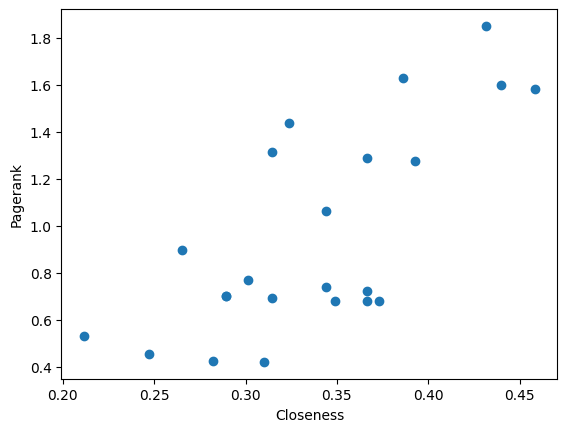

In [60]:
plt.plot(df['closeness'], df['pagerank'], 'o')
plt.xlabel('Closeness')
plt.ylabel('Pagerank')
plt.show()

Text(0.5, 1.0, 'Histograma de los Grados')

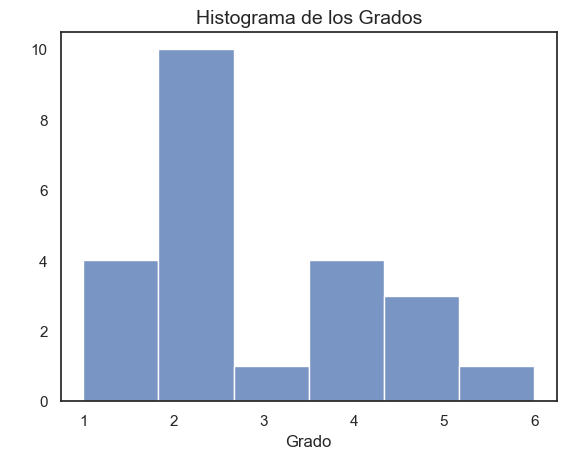

In [75]:
import seaborn as sns
sns.set()

sns.set_style("white")
hist, ax = plt.subplots()
ax = sns.histplot(df['grado'], kde=False)
ax.set_xlabel('Grado')
ax.set_ylabel(' ')
ax.set_title("Histograma de los Grados", fontsize=14)

##### 21) Determinar la correlación entre grado, pagerank, closeness y tiempo_total.
- 21.1) Que variables estan fuertemente correlacionadas?

Todas estan relativamente correlacionadas, pero las mas fuertemente correlacionadas son grado y pagerank.

In [74]:
df.iloc[: , 1: ].corr()

,grado,pagerank,closeness,tiempo_total
grado,1.000000,0.991413,0.777281,0.787785
pagerank,0.991413,1.000000,0.718445,0.772314
closeness,0.777281,0.718445,1.000000,0.671146
tiempo_total,0.787785,0.772314,0.671146,1.000000


##### 22) Eliminar el graph data model, para liberar memoria

In [ ]:
conn.query("gds.graph.drop('saxeburg_traffic')")

##### 23) Cerrar la conexion

In [ ]:
conn.close()